In [1]:
# General
import sys
import os
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/time_cells')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
import spike_preproc
import spike_sorting
import events_preproc

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)
labelfontsize = 12
tickfontsize = 12
figfontsize = 14

## Perform alignment

In [2]:
def read_events_json(subj_sess,
                     proj_dir='/home1/dscho/projects/time_cells',
                     verbose=True):
    """Read events and setup for alignment.
    
    Event times are stored in ms.
    
    Returns
    -------
    events : pd.DataFrame
        Each row is one line of the json file that tracks
        everything logged by the testing laptop during gameplay.
    event_synctimes : np.ndarray
        Vector of sync times for every sync pulse that was sent
        to the EEG recording system.
    """
    subj, sess = subj_sess.split('_')
    events_f = os.path.join(proj_dir, 'data', subj, sess, 'events', 'events.jsonl')
    events = events_preproc.read_json(events_f)
    
    events = events[['time', 'type', 'data']].rename(columns={'type': 'key', 'data': 'value'})
    events['time'] = (events['time'] - events.at[0, 'time'])
    events.insert(0, 'subj_sess', subj_sess)
    event_synctimes = np.array(events.loc[events.key=='syncPulse', 'time'].tolist())
    
    if verbose:
        print('{} events recorded over {} min and {} sec'
              .format(len(events), int(events.iloc[-1]['time']/6e4), int((events.iloc[-1]['time']%6e4)/1e3)))
        
    return events, event_synctimes

In [3]:
def load_syncs(subj_sess,
               data_key='data',
               proj_dir='/home1/dscho/projects/time_cells',
               verbose=True):
    """Load the EEG channel that stores sync pulses from the testing laptop."""
    subj, sess = subj_sess.split('_')
    sync_f = os.path.join(proj_dir, 'data', subj, sess, 'sync', 'sync_channel_micro.mat')
    try:
        sync_chan = np.squeeze(sio.loadmat(sync_f)[data_key])
    except NotImplementedError:
        with h5py.File(sync_f, 'r') as f:
            sync_chan = np.squeeze(f[data_key])
    return sync_chan

In [166]:
reload(events_preproc)

<module 'events_preproc' from '/home1/dscho/code/projects/time_cells/events_preproc.py'>

In [167]:
# Read events file and get event synctimes.
events, event_synctimes = events_preproc.read_events_json(subj_sess)

# Load LFP timestamps.
lfp_timestamps, sr = spike_sorting.load_lfp_timestamps(subj_sess)

# Load the sync channel.
sync_chan = events_preproc.load_syncs(subj_sess, data_key='data')

# Identify sync pulses in the EEG.
pulse_startinds = events_preproc.find_pulse_starts(sync_chan, 
                                                   sampling_rate=sr, 
                                                   pulse_thresh=200, 
                                                   intrapulse_thresh_ms=20, 
                                                   interpulse_thresh_ms=790)
print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

# Get the LFP time in ms for each sync pulse event.
lfp_synctimes = lfp_timestamps[pulse_startinds]

# Get the inter-pulse intervals.
lfp_synctimes_diff = np.diff(lfp_synctimes)
event_synctimes_diff = np.diff(event_synctimes)

89129 events recorded over 76 min and 29 sec
Conversion factor is 1
138652272 timestamps over 77 min and 1.7 s
Sampling rate is 30000 Hz
Detected 4581 EEG sync pulses
Detected 4581 syncs for 4582 sync pulse events


In [168]:
start_time = time()

max_shift = 100
max_slide = 20
step = 5
ipi_thresh = 2

def alternate_2col(stop_at):
    mat = [(0, 0)]
    for x1, x2 in np.vstack((np.zeros(stop_at), np.arange(1, stop_at+1))).T:
        mat.append((x1, x2))
        mat.append((x2, x1))
    mat = np.array(mat).astype(np.int)
    return mat


def eval_ipi_fit(lfp_synctimes_diff,
                 event_synctimes_diff,
                 shift_lfp, 
                 shift_event):
    global shift_lfps
    global shift_events
    ipi_fit = np.max(np.abs(lfp_synctimes_diff[shift_lfp:shift_lfp+step] - 
                            event_synctimes_diff[shift_event:shift_event+step]))
    if ipi_fit < ipi_thresh:
        shift_lfps.append(shift_lfp)
        shift_events.append(shift_event)
        found_fit = True
    else:
        found_fit = False
        
    return found_fit


def find_ipi_fit(lfp_synctimes_diff,
                 event_synctimes_diff):
    n_syncs = np.min((len(lfp_synctimes_diff), len(event_synctimes_diff)))
    shifts = alternate_2col(np.min((n_syncs-(step+1), max_shift)))
    for ii in range(len(shifts)):
        shift_lfp, shift_event = shifts[ii, :]
        found_fit = eval_ipi_fit(lfp_synctimes_diff,
                                 event_synctimes_diff,
                                 shift_lfp,
                                 shift_event)
        if found_fit:
            break
                
    return found_fit
        
    
slides = alternate_2col(max_slide)
lfp_synctimes_adj = []
event_synctimes_adj = []
shift_lfps = []
shift_events = []
loop = 0
while np.min((len(lfp_synctimes_diff), len(event_synctimes_diff))) > (max_slide + step + 1):
    for ii in range(len(slides)):
        slide_lfp, slide_event = slides[ii, :]
        found_fit = find_ipi_fit(lfp_synctimes_diff[slide_lfp:],
                                 event_synctimes_diff[slide_event:])
        if found_fit:
            inc_lfp = slide_lfp + shift_lfps[-1]
            inc_event = slide_event + shift_events[-1]
            
            # Add sync times to the output vectors.
            lfp_synctimes_adj += list(lfp_synctimes[inc_lfp:inc_lfp+step])
            event_synctimes_adj += list(event_synctimes[inc_event:inc_event+step])

            # Remove sync times from the input vectors.
            lfp_synctimes = lfp_synctimes[inc_lfp+step:]
            lfp_synctimes_diff = lfp_synctimes_diff[inc_lfp+step:]
            event_synctimes = event_synctimes[inc_event+step:]
            event_synctimes_diff = event_synctimes_diff[inc_event+step:]
            
            break
    
    if not found_fit:
        print('Loop {}: Inter-sync times failed to converge'.format(loop))
        
        # Jump ahead and try to keep going.
        lfp_synctimes = lfp_synctimes[max_slide+step:]
        lfp_synctimes_diff = lfp_synctimes_diff[max_slide+step:]
        event_synctimes = event_synctimes[max_slide+step:]
        event_synctimes_diff = event_synctimes_diff[max_slide+step:]
        
    loop += 1
    
event_synctimes_adj = np.array(event_synctimes_adj)
lfp_synctimes_adj = np.array(lfp_synctimes_adj)
    
print('Retained {} sync pulses'.format(len(lfp_synctimes_adj)))

print('Done in {:.2f} s'.format(time() - start_time))

Retained 4420 sync pulses
Done in 0.68 s


In [169]:
alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                             lfp_synctimes_adj)

# Apply the alignment to all event times.
events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))

# How did our alignment go?
print('{} event sync pulses'.format(len(event_synctimes_adj)))
print('{} LFP sync pulses identified'.format(len(lfp_synctimes_adj)))
print('\n--------------------\nAlignment parameters\n--------------------')
for k, v in alignment.items():
    print('{}: {}'.format(k, v))

59 event sync pulses
25 LFP sync pulses identified

--------------------
Alignment parameters
--------------------
sync_params: OrderedDict([('intercept', 66881.90640837472), ('slope', 1.000014931672197)])
before_stats: OrderedDict([('ipi_r', 0.9999998016024779), ('ipi_diff', 0.17343140798860415), ('rmse', 66915.70320794046), ('err_pcts', 0      66883.316813
1      66883.890088
5      66885.836611
10     66888.703105
25     66898.478365
50     66915.686637
75     66932.830066
90     66942.814650
95     66946.230199
99     66948.845459
100    66949.696842
dtype: float64)])
after_stats: OrderedDict([('ipi_r', 0.9999998016024779), ('ipi_diff', 0.1729700430429433), ('rmse', 0.3066750024181425), ('err_pcts', 0      0.000026
1      0.003531
5      0.016707
10     0.031731
25     0.076930
50     0.152424
75     0.241296
90     0.370756
95     0.583473
99     1.312746
100    1.769985
dtype: float64)])
sync_pairs: [[6.16030029e+02 6.74995667e+04]
 [1.42725000e+03 6.83107667e+04]
 [2.49771997e+0

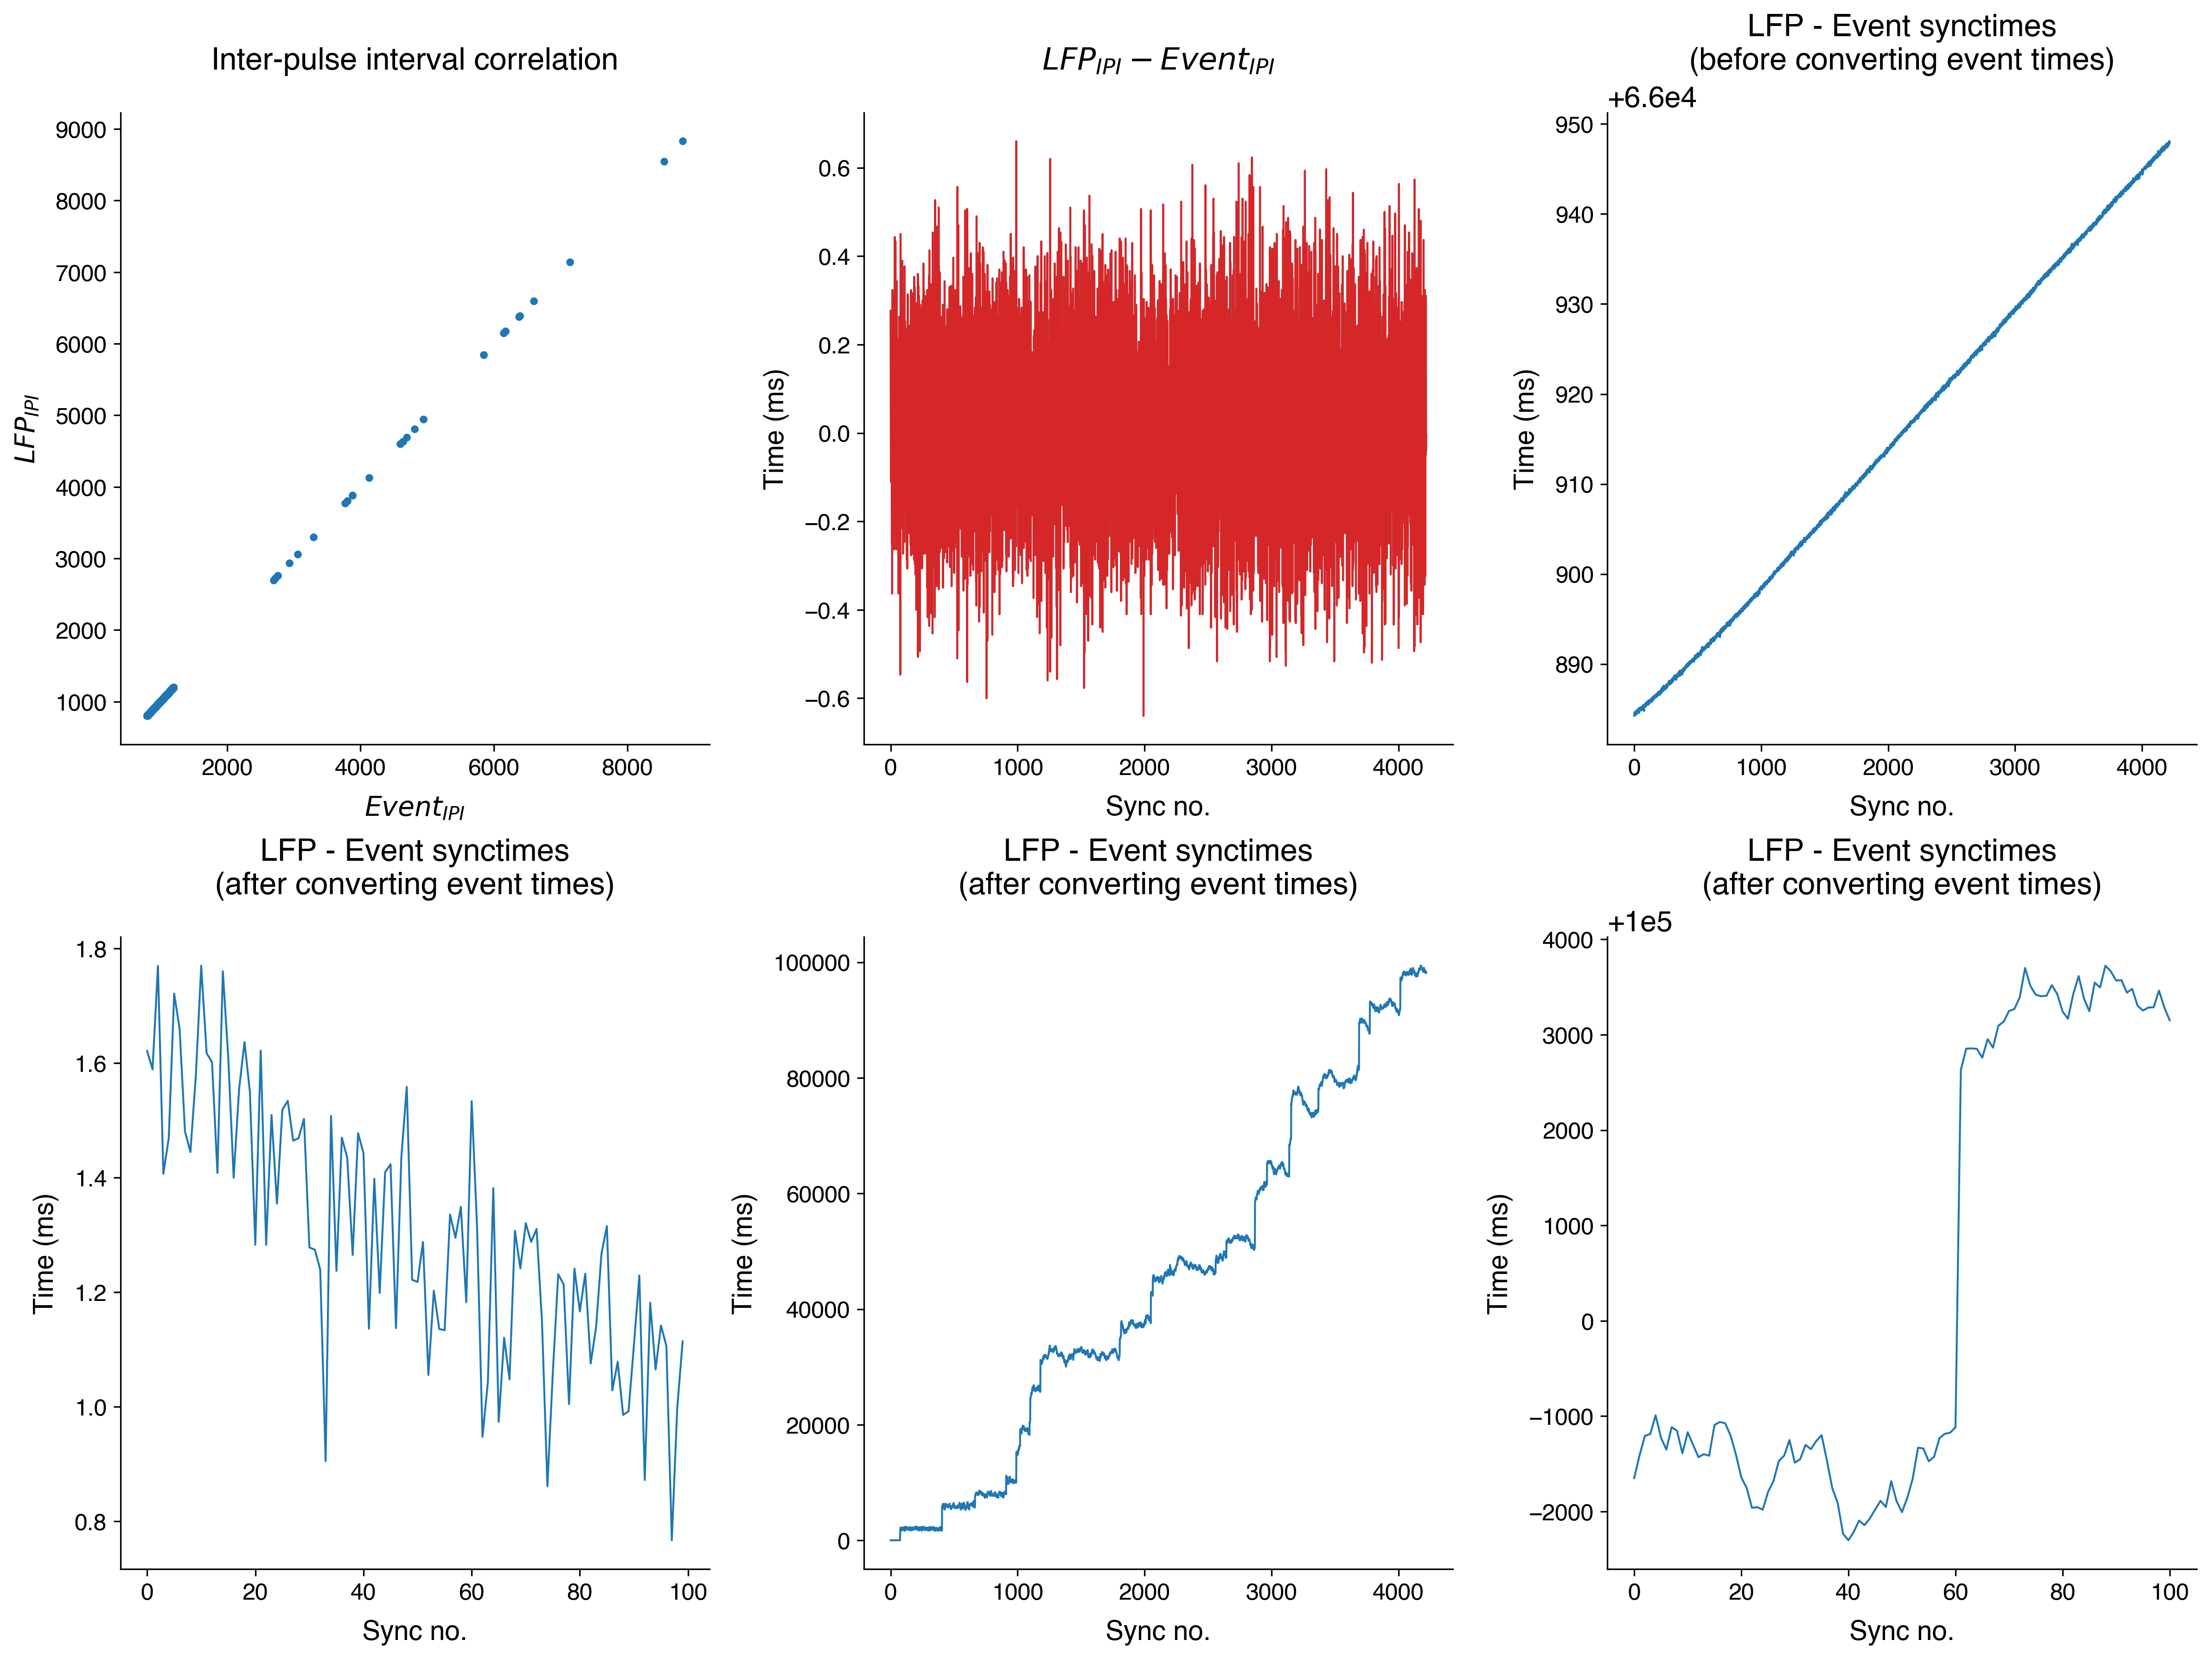

In [172]:
fig, ax = plt.subplots(2, 3, figsize=(16, 12), dpi=300)
ax = np.ravel(ax)

axisfontsize = 12
labelfontsize = 14
titlefontsize = 16

min_syncs = np.min((len(event_synctimes_adj), len(lfp_synctimes_adj)))
start = 100
stop = min_syncs - 101

i = 0
ax[i].scatter(np.diff(event_synctimes_adj), np.diff(lfp_synctimes_adj))
ax[i].set_xlabel('$Event_{IPI}$', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('$LFP_{IPI}$', fontsize=labelfontsize, labelpad=8)
ax[i].set_title('Inter-pulse interval correlation', fontsize=titlefontsize, y=1.05)

i = 1
shift_by_ = 0
ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
ax[i].set_xlabel('Sync no.', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Time (ms)', fontsize=labelfontsize, labelpad=8)
ax[i].set_title('$LFP_{IPI} - Event_{IPI}$', fontsize=titlefontsize, y=1.05)

i = 2
ax[i].plot(lfp_synctimes_adj[start:stop] - event_synctimes_adj[start:stop])
ax[i].set_xlabel('Sync no.', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Time (ms)', fontsize=labelfontsize, labelpad=8)
ax[i].set_title('LFP - Event synctimes\n(before converting event times)', fontsize=titlefontsize, y=1.05)

i = 3
ax[i].plot(lfp_synctimes_adj[:start] - events.loc[events.key=='syncPulse', 'time'].values[:start])
ax[i].set_xlabel('Sync no.', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Time (ms)', fontsize=labelfontsize, labelpad=8)
ax[i].set_title('LFP - Event synctimes\n(after converting event times)', fontsize=titlefontsize, y=1.05)

i = 4
ax[i].plot(lfp_synctimes_adj[start:stop] - events.loc[events.key=='syncPulse', 'time'].values[start:stop])
ax[i].set_xlabel('Sync no.', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Time (ms)', fontsize=labelfontsize, labelpad=8)
ax[i].set_title('LFP - Event synctimes\n(after converting event times)', fontsize=titlefontsize, y=1.05)

i = 5
ax[i].plot(lfp_synctimes_adj[stop:min_syncs] - events.loc[events.key=='syncPulse', 'time'].values[stop:min_syncs])
ax[i].set_xlabel('Sync no.', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Time (ms)', fontsize=labelfontsize, labelpad=8)
ax[i].set_title('LFP - Event synctimes\n(after converting event times)', fontsize=titlefontsize, y=1.05)

for i in range(len(ax)):
    ax[i].tick_params(axis='both', which='major', labelsize=tickfontsize)
fig.tight_layout()

In [205]:
sync_thresh = 2 # ms
pulse_startinds_aligned = []
sync_times_ = events.loc[events.key=='syncPulse', 'time']
for event_sync_time in sync_times_:
    diff_ = np.abs(lfp_synctimes_adj - event_sync_time)
    argmin_ = np.argmin(diff_)
    min_ = diff_[argmin_]
    if min_ < sync_thresh:
        pulse_startinds_aligned.append(pulse_startinds[argmin_])
pulse_startinds_aligned = np.array(pulse_startinds_aligned)

print('{} sync pulses and {} aligned sync pulses in the LFP'.format(len(sync_times_), len(pulse_startinds_aligned)))

4582 sync pulses and 4420 aligned sync pulses in the LFP


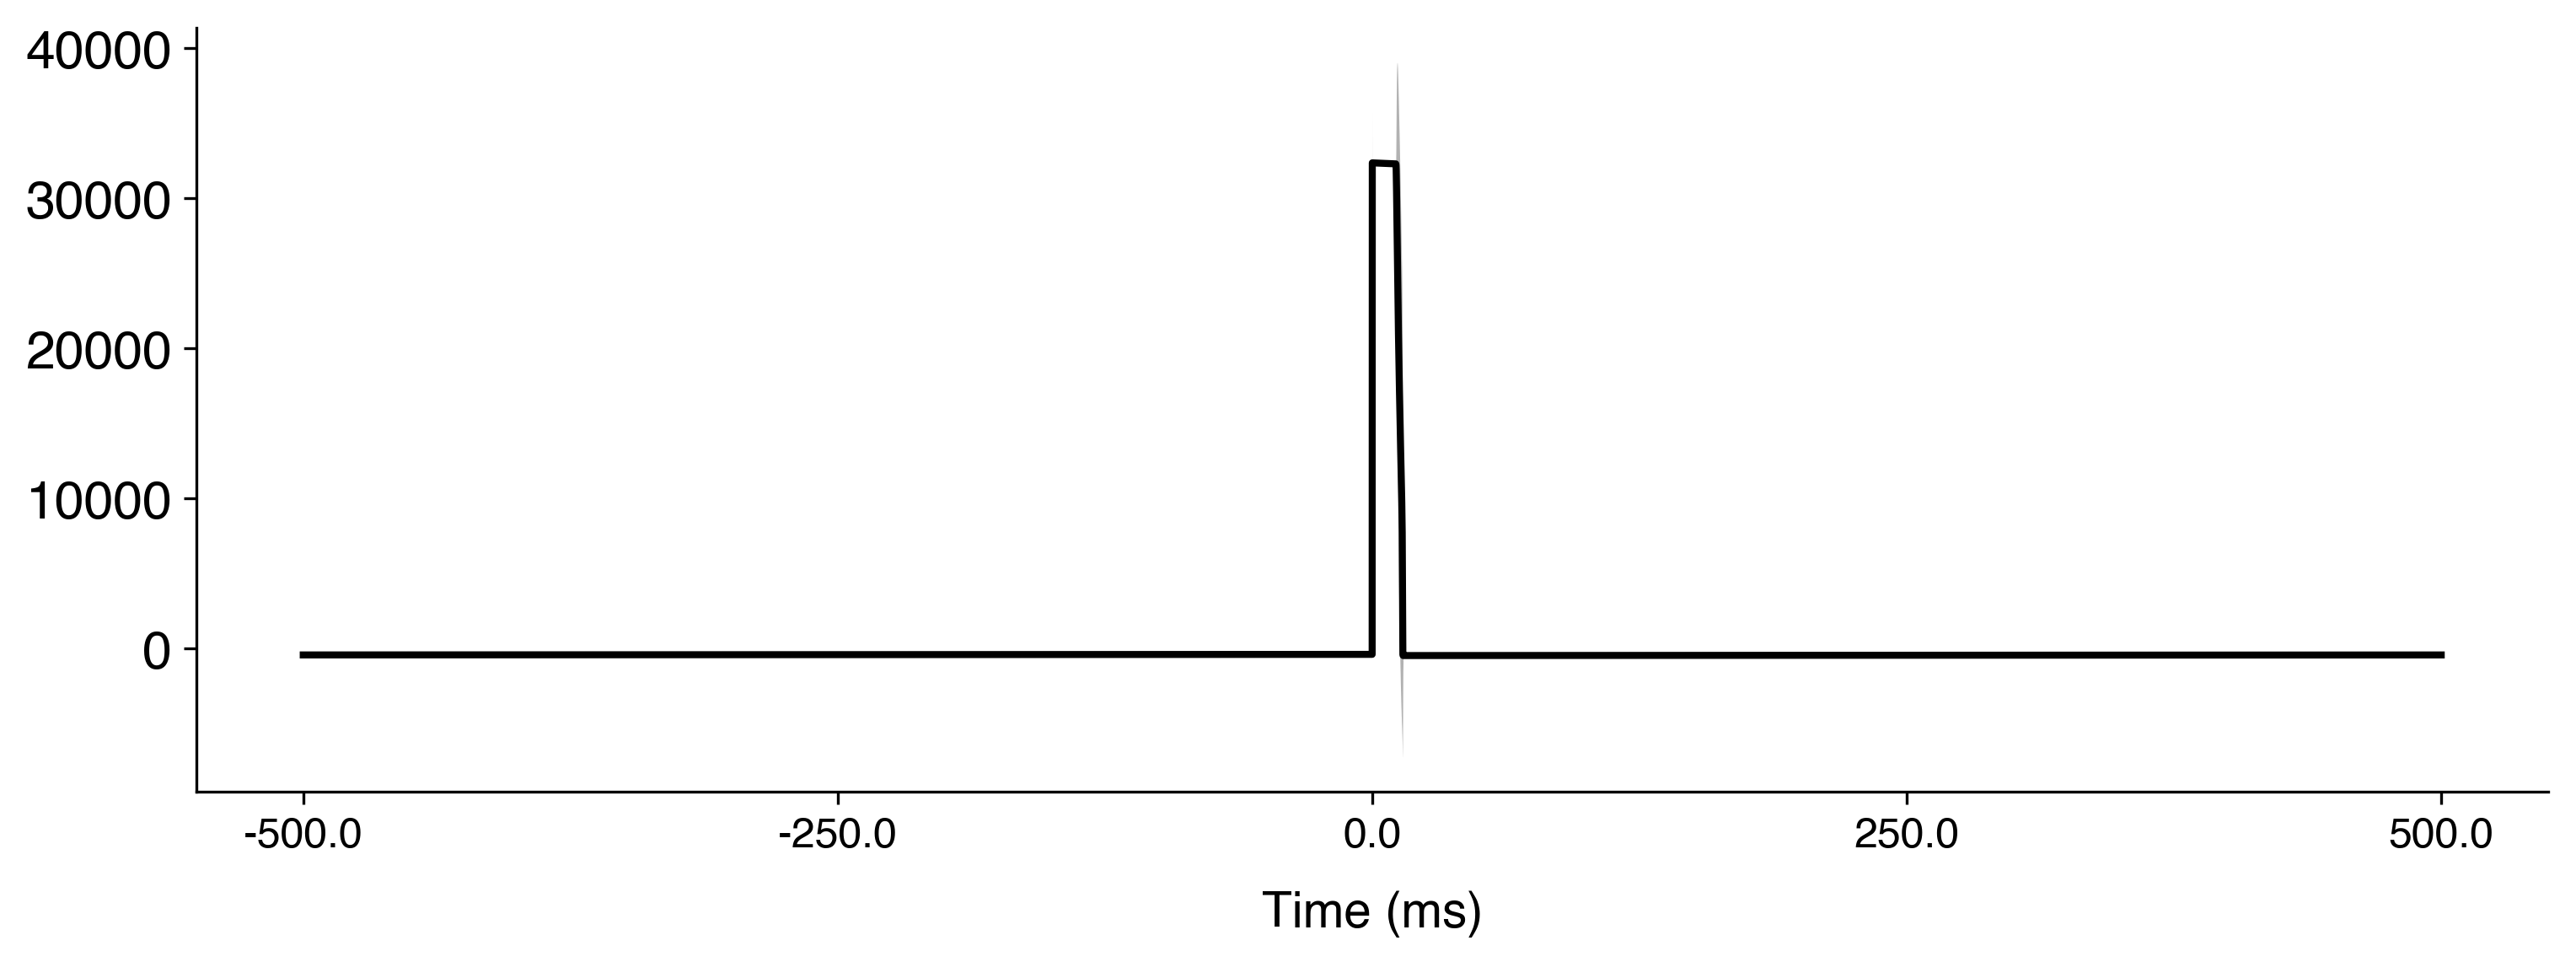

In [207]:
# Plot the sync-triggered average on the sync channel
# to check that event times are aligned with sync pulses
sta = np.array([sync_chan[ind-int(sr/2):ind+int(sr/2)+1]
                for ind in np.rint(pulse_startinds_aligned[1:-1]).astype(np.int)]) # sync x time
mean_sta = np.mean(sta, axis=0)
std_sta = np.std(sta, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

i = 0
x_ax = np.arange(sr+1)
ax[i].fill_between(x_ax, mean_sta + std_sta, mean_sta - std_sta, color='k', alpha=0.3, linewidth=0)
ax[i].plot(x_ax, mean_sta, color='k', linewidth=2)
ax[i].set_xticks(np.linspace(x_ax[0], x_ax[-1], 5))
ax[i].set_xticklabels(np.linspace(-500, 500, 5), fontsize=tickfontsize)
ax[i].set_xlabel('Time (ms)', fontsize=labelfontsize, labelpad=10)

fig.show()

In [210]:
event_synctimes = events.loc[events.key=='syncPulse', 'time'].values
event_pulse_inds = (np.array([x for x in (event_synctimes-lfp_timestamps[0]) * (sr/1e3) 
                              if x<len(lfp_timestamps)])).astype(np.int64)
event_pulse_startinds_train = np.zeros(len(sync_chan))
event_pulse_startinds_train[event_pulse_inds] = 1

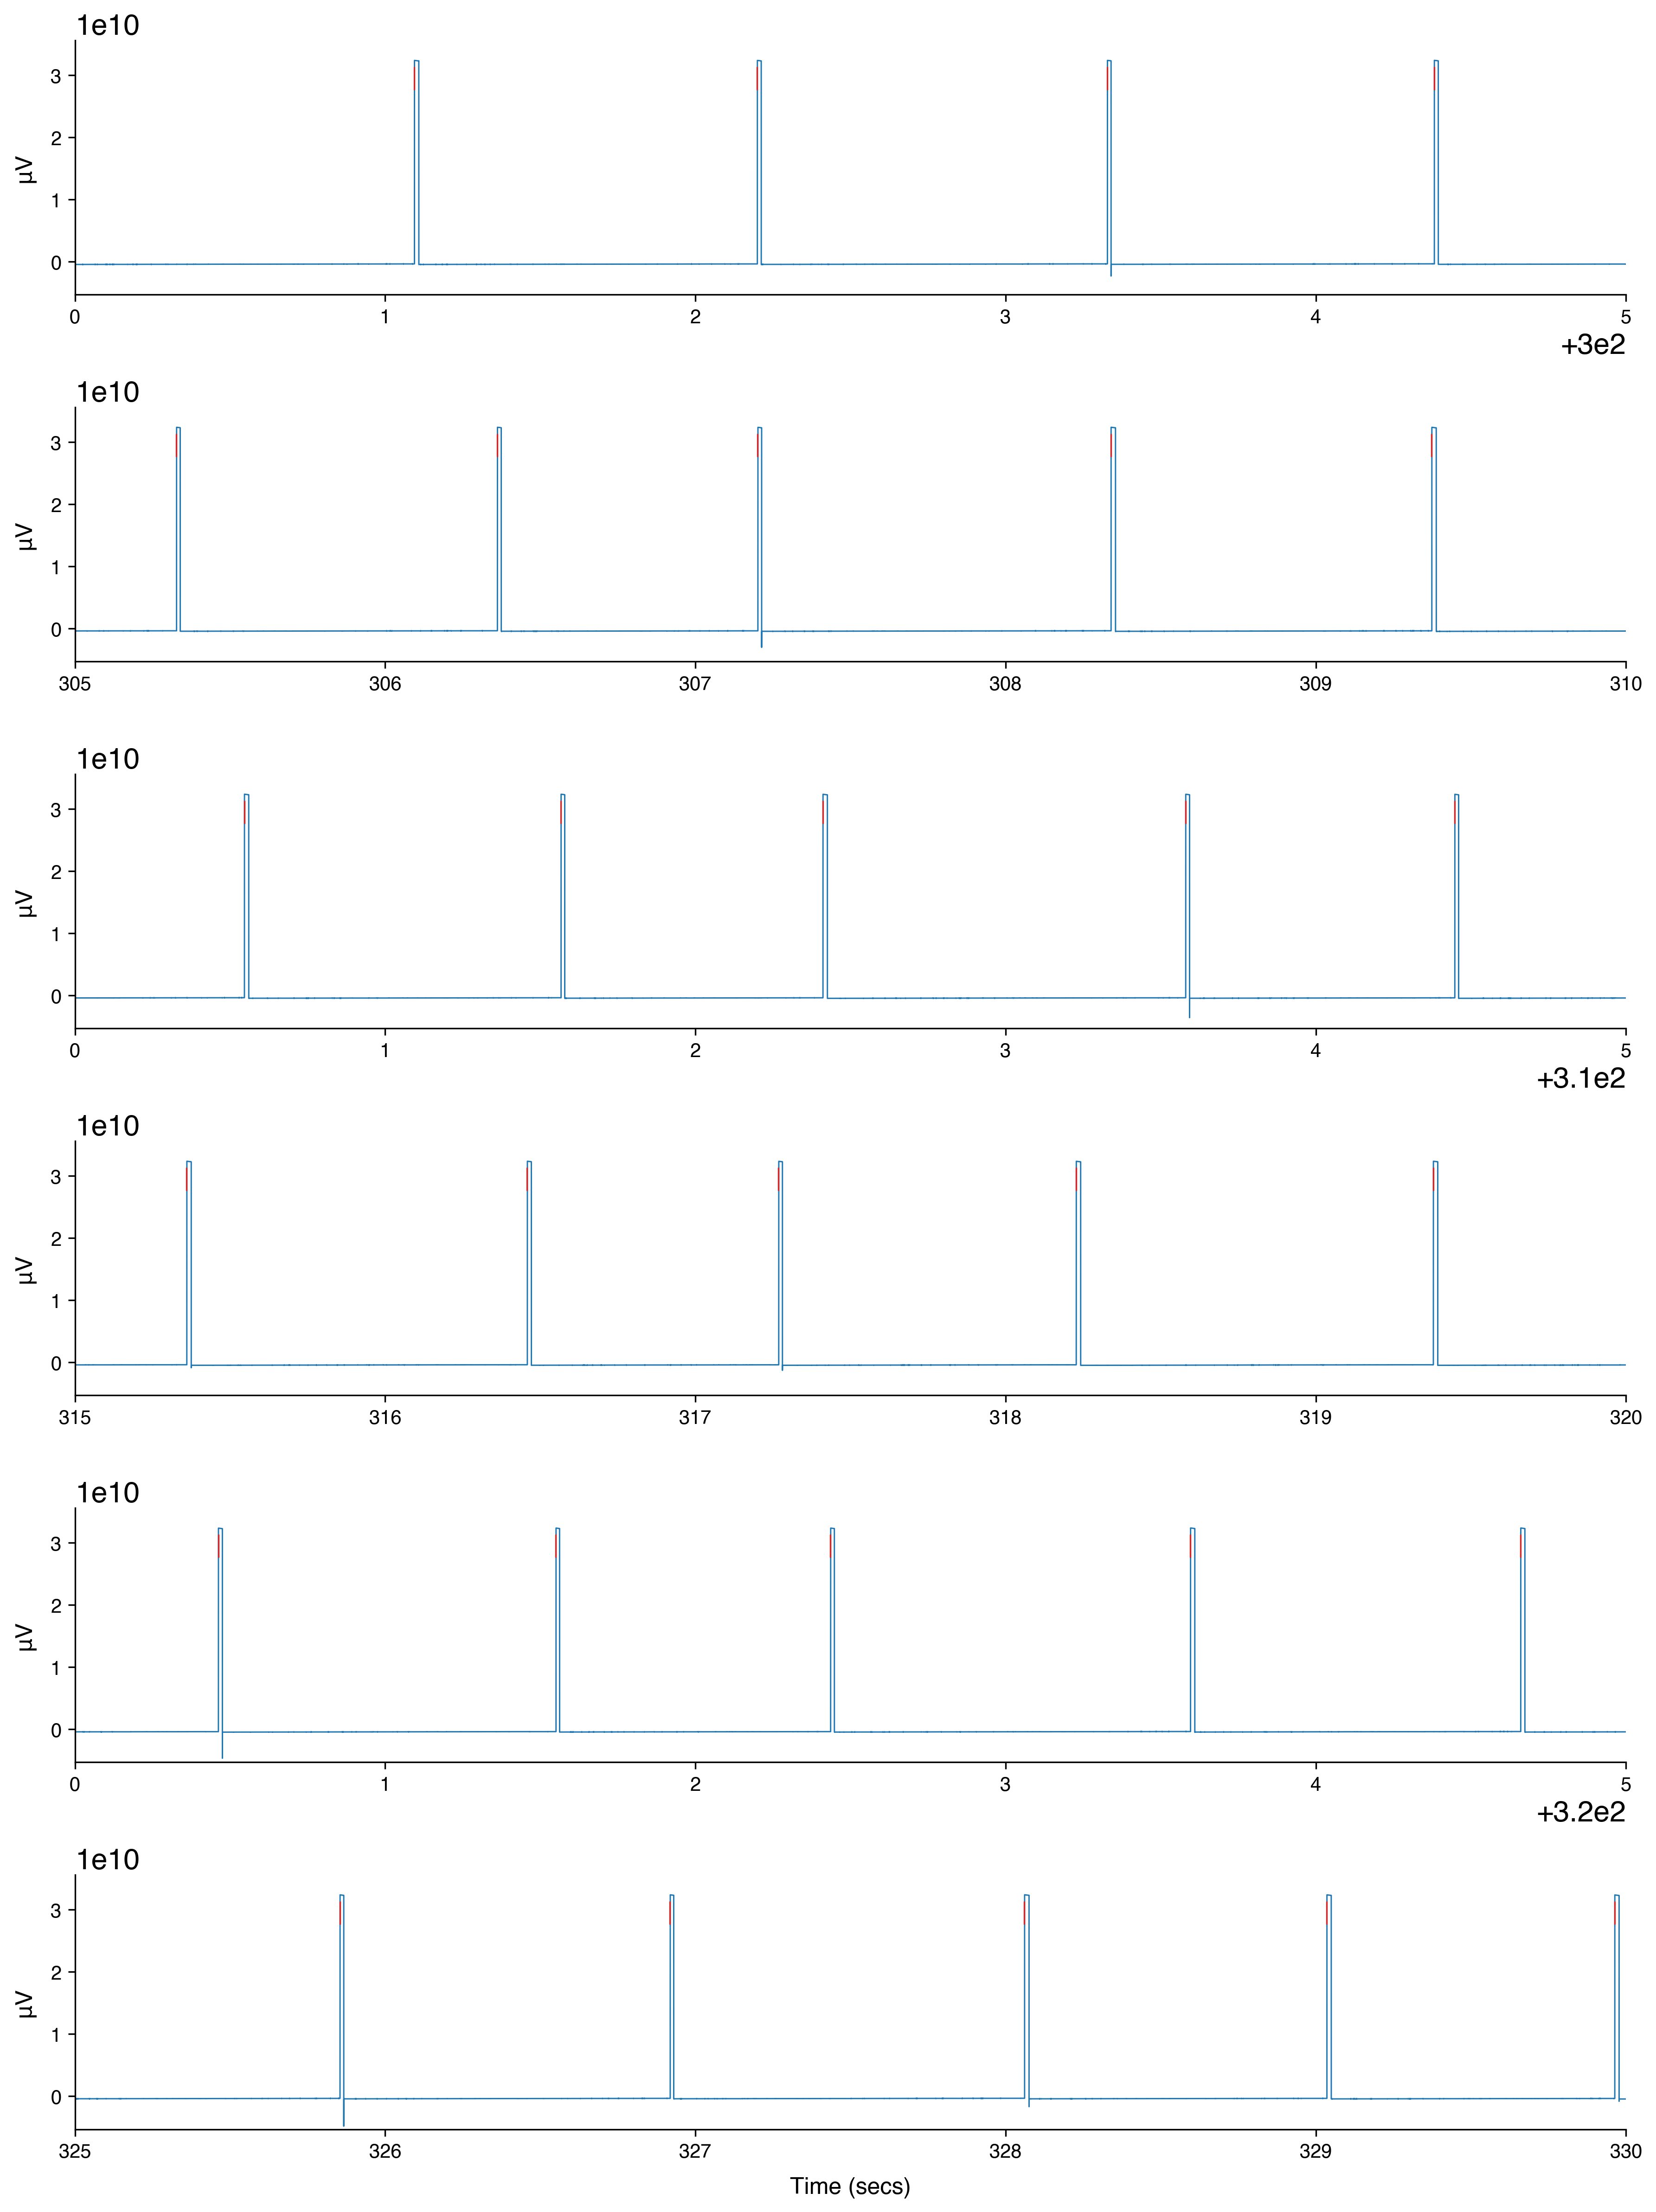

In [211]:
fig, ax = plot_trace2(sync_chan, spike_dat=event_pulse_startinds_train,
                      start=300, duration=30, nwin=6, x_units='secs', sampling_rate=sr)

## Format events

In [117]:
dio.save_pickle(events, os.path.join(proj_dir, 'analysis', 'events', '{}-events_formatted.pkl'.format(subj_sess)))

Saved /home1/dscho/projects/time_cells/analysis/U527_ses0-events_formatted.pkl


In [214]:
events = events_preproc.format_events(events=events.copy(),
                                      overwrite=True,
                                      save_output=True,
                                      proj_dir='/home1/dscho/projects/time_cells',
                                      verbose=True)

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Removing incomplete trials and trials with a manual pause...

trial  gameState  
0      DoNextTrial    [incomplete]
       InitTrial      [incomplete]
Name: bad_trials, dtype: object

Main experiment has 78187 events recorded over 58 min and 24 sec
Saved /home1/dscho/projects/time_cells/analysis/events/U530_ses0-events_formatted.pkl


In [217]:
event_times = events_preproc.create_event_time_bins(subj_sess,
                                                    overwrite=True,
                                                    save_output=True,
                                                    verbose=True)

Saved /home1/dscho/projects/time_cells/analysis/events/event_times/U530_ses0-event_times


## Load ses0 spike data

In [226]:
spikes = spike_preproc.format_spikes(subj_sess,
                                     n_spike_thresh=0,
                                     fr_thresh=0.1,
                                     proj_dir='/home1/dscho/projects/time_cells',
                                     spikes_dirname='wave_clus3_sortbyhand',
                                     overwrite=True,
                                     save_output=True,
                                     split_files=True,
                                     verbose=True)

Conversion factor is 1
138652272 timestamps over 77 min and 1.7 s
Sampling rate is 30000 Hz
Found 96 wave_clus files.

Found 67 neurons
Firing rates:
count    67.000000
mean      3.956923
std       4.644488
min       0.102559
25%       0.717262
50%       1.930224
75%       5.107598
max      21.183786
Name: fr, dtype: float64

         unit  chan         fr
hemroi                        
LA         13     8   0.455456
LAC         2     2   3.156277
LEC        18     8   3.032947
LHGa        9     6   8.215300
LMH         1     1  12.387320
LPI-SMG     2     1   0.868828
RAC         1     1   1.163630
REC        14     6   2.340351
RMH         4     3   6.867864
ROF         3     2   2.564184
Saved /home1/dscho/projects/time_cells/analysis/spikes/U530_ses0-CSC2-unit1-spikes.pkl
Saved /home1/dscho/projects/time_cells/analysis/spikes/U530_ses0-CSC2-unit2-spikes.pkl
Saved /home1/dscho/projects/time_cells/analysis/spikes/U530_ses0-CSC3-unit1-spikes.pkl
Saved /home1/dscho/projects/time_cells/

In [227]:
# Format wave_clus outputs and generate a spike null distribution.
start_time = time()

spikes = spike_preproc.add_null_to_spikes(subj_sess, 
                                          event_times, 
                                          n_perms=1000, 
                                          verbose=True,
                                          save_output=True)

print('Done in {:.2f} s'.format(time() - start_time))

KeyboardInterrupt: 